# CAST AI Task Solution

In this notebook we will be exploring a dataset provided to us for the purposes of EDA and modelling

In [1]:
import numpy as np
import pandas as pd

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import importlib

In [33]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [59]:
import datautils.DataSampler
import datautils.ClassRebalancer
import utils.EDA
import features.FeatureEngineer

In [58]:
importlib.reload(datautils.DataSampler)
importlib.reload(datautils.ClassRebalancer)
importlib.reload(utils.EDA)
importlib.reload(features.FeatureEngineer)

<module 'features.FeatureEngineer' from 'c:\\Users\\vctrg\\OneDrive\\Documents\\Github\\CastAITask\\code\\features\\FeatureEngineer.py'>

In [6]:
data_sampler = datautils.DataSampler.DataSampler(file_path='../data/data.parquet')

In [7]:
sample_df = data_sampler.sample_data()

In [65]:
mini_sample_df = sample_df.sample(frac=0.1)

## Exploratory Analysis (EDA)

### Initial Thoughts

Without a detailed data schema indicating what each of the column fields represent, and considering the high number of purely numerical columns, we are left to explore the data purely from an analytical perspective. Indeed, considering the number of fields and data, we additionally examine the columns at a macro level as well, where we look at properties such as multi-collinearity (correlations between one variable and one or more other variables), missing values present, overall skewness in distribution that can be re-normalised, and so on. 

With the above in mind, we proceed below with a cursory overview of the data, followed by more in-depth overviews of the data using our EDA helper tool, which will give us correlation matrices, a PCA analysis to help diagnose multi-collinearity via explained variance in a more 'compressed' version of the data, and more.

In [13]:
# inspect the final sampled data
print(f"Total sampled rows: {len(sample_df)}")
sample_df.head()

   col_0_numeric  col_1_numeric  col_2_numeric  col_3_numeric  col_4_numeric  \
0            NaN       7.867676            NaN     128.931351      17.629303   
1     279.890564      48.967163            NaN     116.851036       4.281593   
2     279.890564      48.967163            NaN            NaN       4.281593   
3     584.797058       7.098282            NaN     128.085892      13.206445   
4     270.983551      40.060154            NaN     107.944023       0.476529   

   col_5_numeric  col_6_numeric  col_7_numeric  col_8_numeric  col_9_numeric  \
0      26.530045            NaN            NaN     126.621559      38.153298   
1       9.038982            NaN            NaN      40.208366     129.435634   
2       9.038982            NaN            NaN       9.383539     643.626357   
3       5.827094            NaN            NaN     385.543640     299.987374   
4       0.131972            NaN            NaN      31.301357     120.528623   

   col_10_numeric  col_11_numeric  col

In [14]:
sample_df.describe()


,col_0_numeric,col_1_numeric,col_2_numeric,col_3_numeric,col_4_numeric,col_5_numeric,col_6_numeric,col_7_numeric,col_8_numeric,col_9_numeric,col_10_numeric,col_11_numeric,col_12_numeric,col_13_numeric,col_15_string,col_16_string,col_17_numeric,col_18_numeric,col_19_numeric,col_20_numeric,col_21_numeric,col_22_numeric,col_23_numeric,col_24_numeric,col_25_numeric,col_26_numeric,col_27_numeric,col_28_numeric,col_29_numeric,col_30_numeric,col_31_numeric,col_32_numeric,col_33_numeric,col_34_numeric,col_35_numeric,col_36_numeric,col_37_numeric,col_38_numeric,col_39_numeric,col_40_numeric,col_41_numeric,col_42_numeric,col_43_numeric,col_44_numeric,col_45_numeric,col_46_numeric,col_47_numeric,col_48_numeric,col_49_numeric,col_50_numeric,col_51_numeric,col_52_numeric,col_53_numeric,col_54_numeric,col_55_numeric,col_56_numeric,col_57_numeric,col_58_numeric,col_59_numeric,col_60_numeric,col_61_numeric,col_62_numeric,col_63_numeric,col_64_numeric,col_65_numeric,col_66_numeric,col_67_numeric,col_68_numeric,col_69_numeric,col_70_numeric,col_71_numeric,col_72_numeric,col_73_numeric,col_74_numeric,col_75_numeric,col_76_numeric,col_77_numeric,col_78_numeric,col_79_numeric,col_80_numeric,col_81_numeric,col_82_numeric,col_83_numeric,col_84_numeric,col_85_numeric,col_86_numeric,col_87_numeric,col_88_numeric,col_89_numeric,col_90_numeric,col_91_numeric,col_92_numeric,col_93_numeric,col_94_numeric,col_95_numeric,col_96_numeric,col_97_numeric,col_98_numeric,col_99_numeric,col_100_numeric,col_101_numeric,col_102_numeric,col_103_numeric,col_104_numeric,col_105_numeric,col_106_numeric,col_107_numeric,col_108_numeric,col_109_numeric,col_110_numeric,col_111_numeric,col_112_numeric,col_113_numeric,col_114_numeric,col_115_numeric,col_116_numeric,col_117_numeric,col_118_numeric,col_119_numeric,col_120_numeric,col_121_numeric,col_122_numeric,col_123_numeric,col_124_numeric,col_125_numeric,col_126_numeric,col_127_numeric,col_128_numeric,col_129_numeric,col_130_numeric,col_131_numeric,col_132_numeric,col_133_numeric,col_134_numeric,col_135_numeric,col_136_numeric,col_137_numeric,col_138_numeric,col_139_numeric,col_140_numeric,col_141_numeric,col_142_numeric,col_143_numeric,col_144_numeric,col_145_numeric,col_146_numeric,col_147_numeric,col_148_numeric,col_149_numeric,col_150_numeric,col_151_numeric,col_152_numeric,col_153_numeric,col_154_numeric,col_155_numeric,col_156_numeric,col_157_numeric,col_158_numeric,col_159_numeric,col_160_numeric,col_161_numeric,col_162_numeric,col_163_numeric,col_164_numeric,col_165_numeric,col_166_numeric,col_167_numeric,col_168_numeric,col_169_numeric,col_170_numeric,col_171_numeric,col_172_numeric,col_173_numeric,col_174_numeric,col_175_numeric,col_176_numeric,col_177_numeric,col_178_numeric,col_179_numeric,col_180_numeric,col_181_numeric,col_182_numeric,col_183_numeric,col_184_numeric,col_185_numeric,col_186_numeric,col_187_numeric,col_188_numeric,col_189_numeric,col_190_numeric,col_191_numeric,col_192_numeric,col_193_numeric,col_194_numeric,col_195_numeric,col_196_numeric,col_197_numeric,col_198_numeric,col_199_numeric,col_200_numeric,col_201_numeric,col_202_numeric,col_203_numeric,col_204_numeric,col_205_numeric,col_206_numeric,col_207_numeric,col_208_numeric,col_209_numeric,col_210_numeric,col_211_numeric,col_212_numeric,col_213_numeric,col_214_numeric,col_215_numeric,col_216_numeric,col_217_numeric,col_218_numeric,col_219_numeric,col_220_numeric,col_221_numeric,col_222_numeric,col_223_numeric,col_224_numeric,col_225_numeric,col_226_numeric,col_227_numeric,col_228_numeric,col_229_numeric,col_230_numeric,col_231_numeric,col_232_numeric,col_233_numeric,col_234_numeric,col_235_numeric,col_236_numeric,col_237_numeric,col_238_numeric,col_239_numeric,col_240_numeric,col_241_numeric,col_242_numeric,col_243_numeric,col_244_numeric,col_245_numeric,col_246_numeric,col_247_numeric,col_248_numeric,col_249_numeric,col_250_numeric,col_251_numeric,col_252_numeric,col_253_numeric,col_254_numeric,col_255_numeric,col_256_numeric,col_257_numeri

In [23]:
sample_df['label'].value_counts()

label
Continue       568364
Interrupted    166665
Name: count, dtype: int64

In [28]:
# Assuming `final_sample_df` contains the sampled data
eda = utils.EDA.EDA(sample_df)

In [16]:
# Step 1: Descriptive statistics
eda.descriptive_stats()

Numerical Features Summary:
       col_0_numeric  col_1_numeric  col_2_numeric  col_3_numeric  \
count  472095.000000  724393.000000    4839.000000  376323.000000   
mean      283.675720      29.789457     604.134277     369.977753   
min         0.749260       0.451152       1.310225       0.477189   
25%        31.373934       2.710483     235.044754      40.132641   
50%       108.841454       5.282733     528.297241     170.090424   
75%       423.087402      14.610612     986.326416     640.176147   
max      1468.376953    1464.911133    1467.565308    1469.899780   
std       354.163544     101.664803     415.237122     412.642273   

       col_4_numeric  col_5_numeric  col_6_numeric  col_7_numeric  \
count  732791.000000  732980.000000   11739.000000  129597.000000   
mean       11.268540      14.383420     590.830750     561.182007   
min         0.075249       0.005144       0.472780       0.005640   
25%         1.697152       1.253813     207.284210     177.790054   
50%  

In [32]:
# Step 2: Check for missing values
eda.missing_values()

Missing Values:
 col_0_numeric      262934
col_1_numeric       10636
col_2_numeric      730190
col_3_numeric      358706
col_4_numeric        2238
                    ...  
col_323_numeric    267971
col_324_numeric     59510
col_325_numeric    267971
label                   0
col_327_other           0
Length: 328, dtype: int64


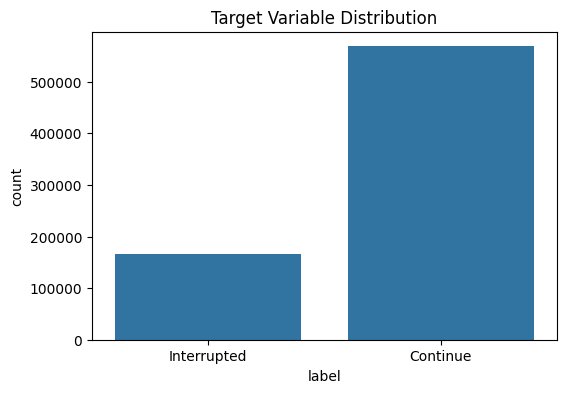

In [9]:
# Step 3: Target distribution
eda.target_distribution()

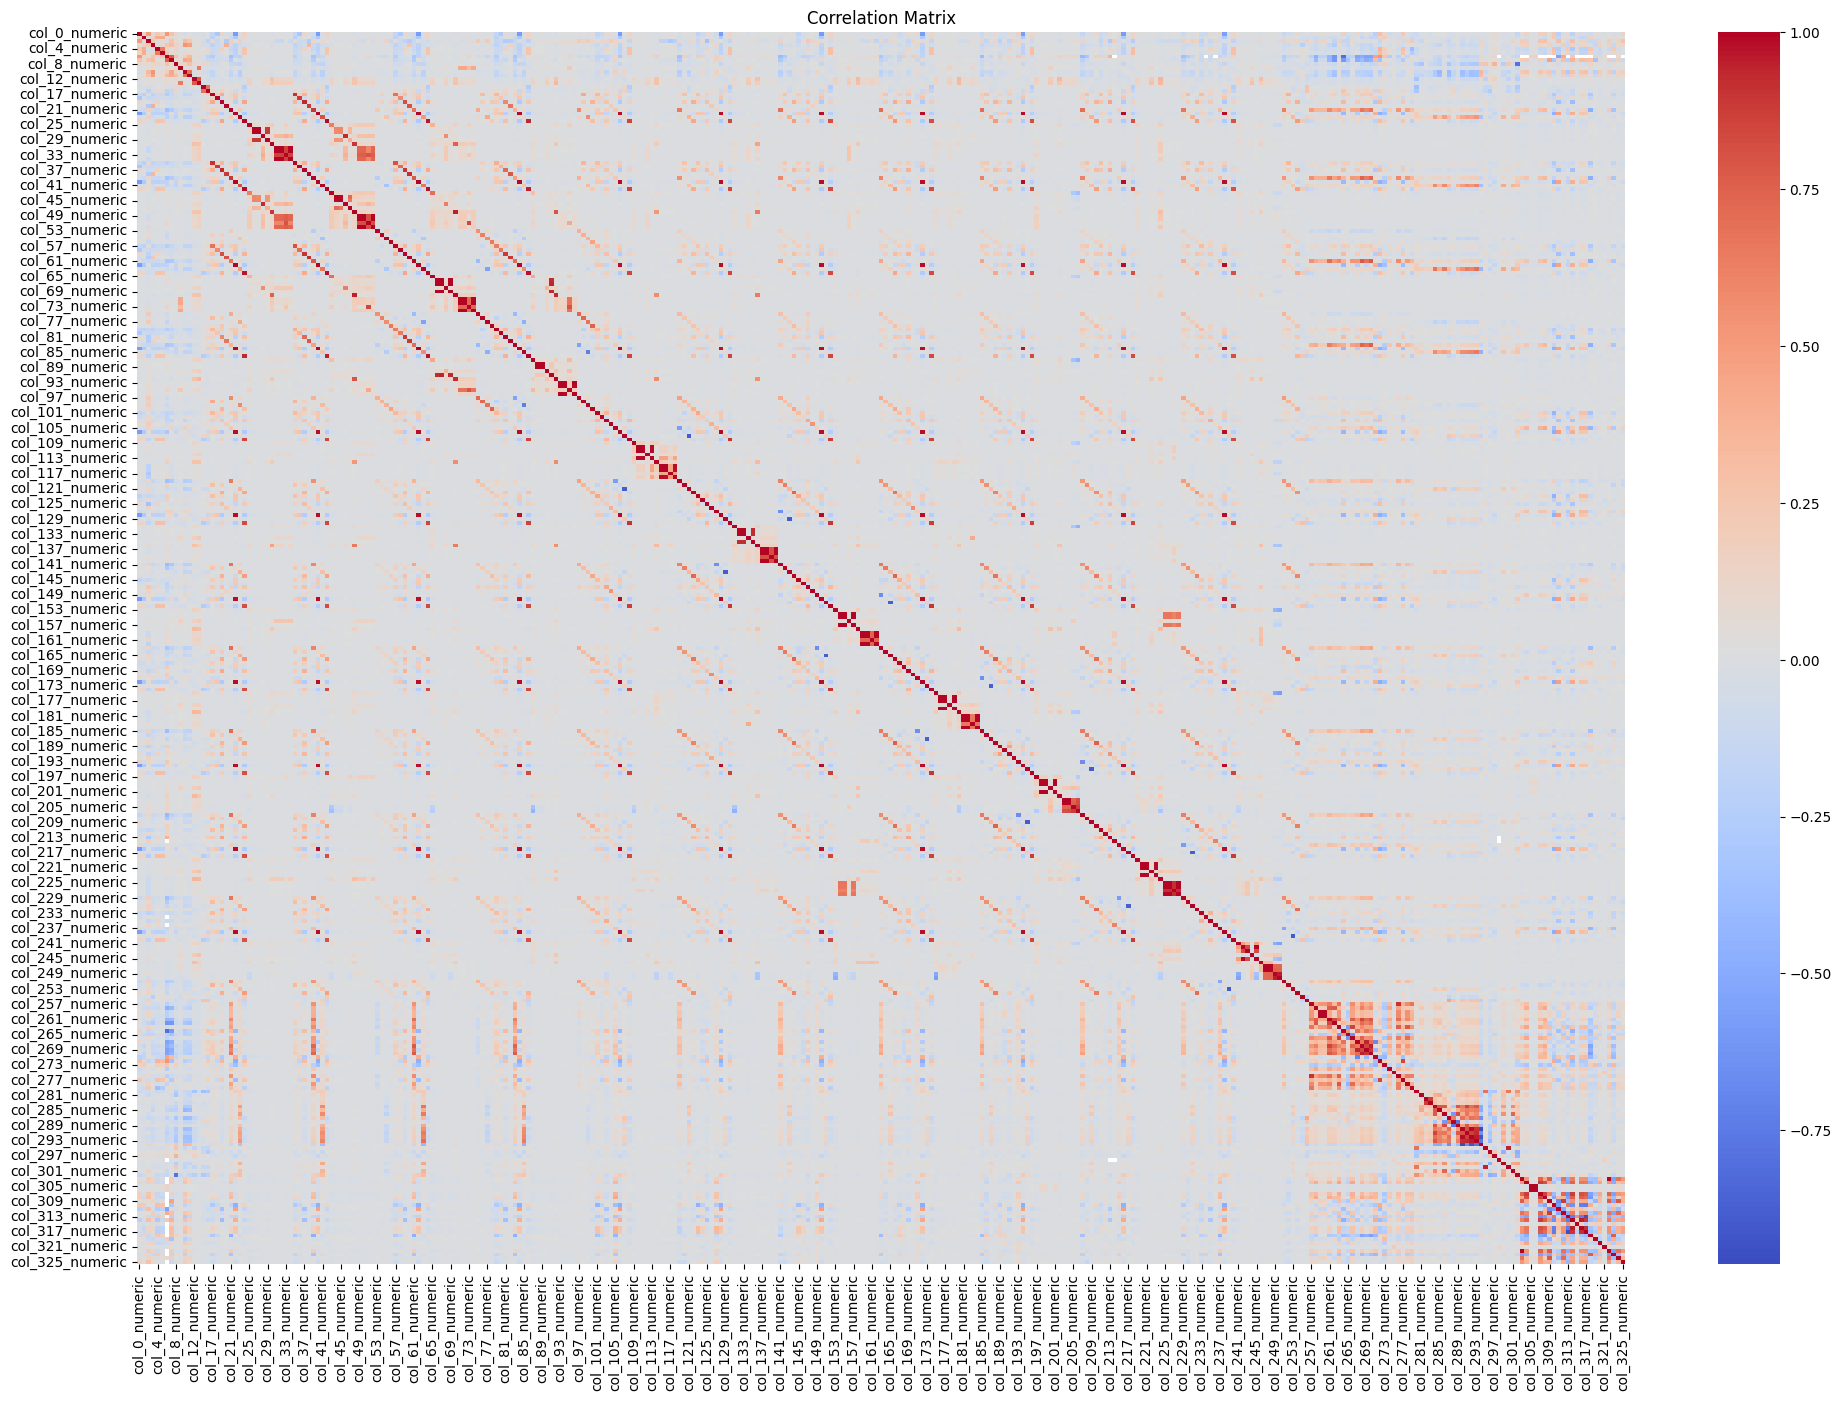

In [18]:
# Step 4: Correlation matrix
eda.correlation_matrix()

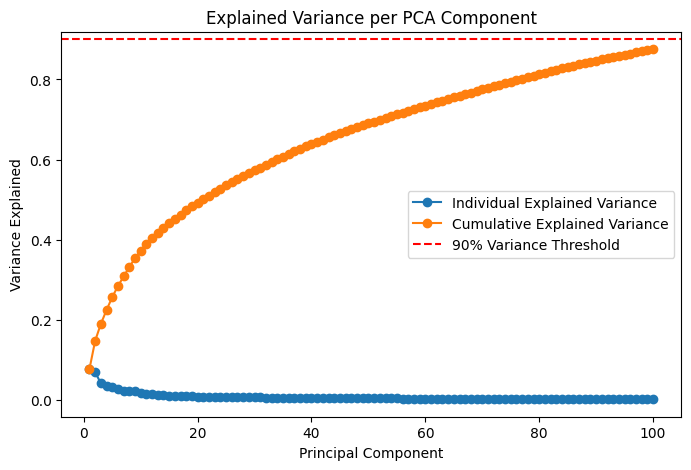

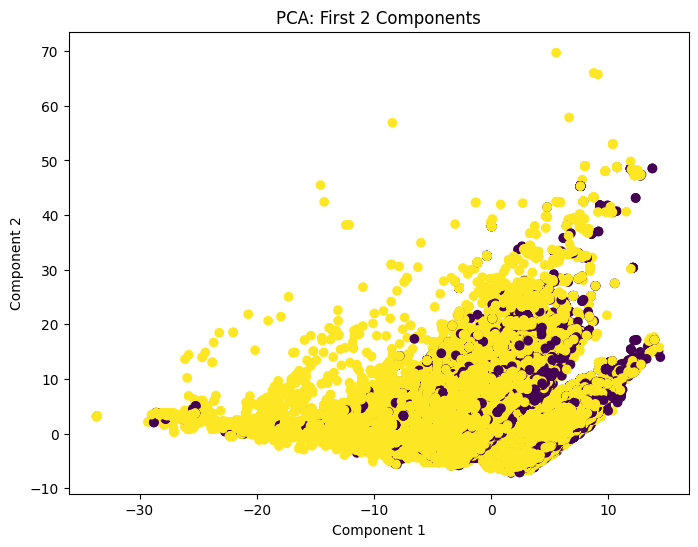

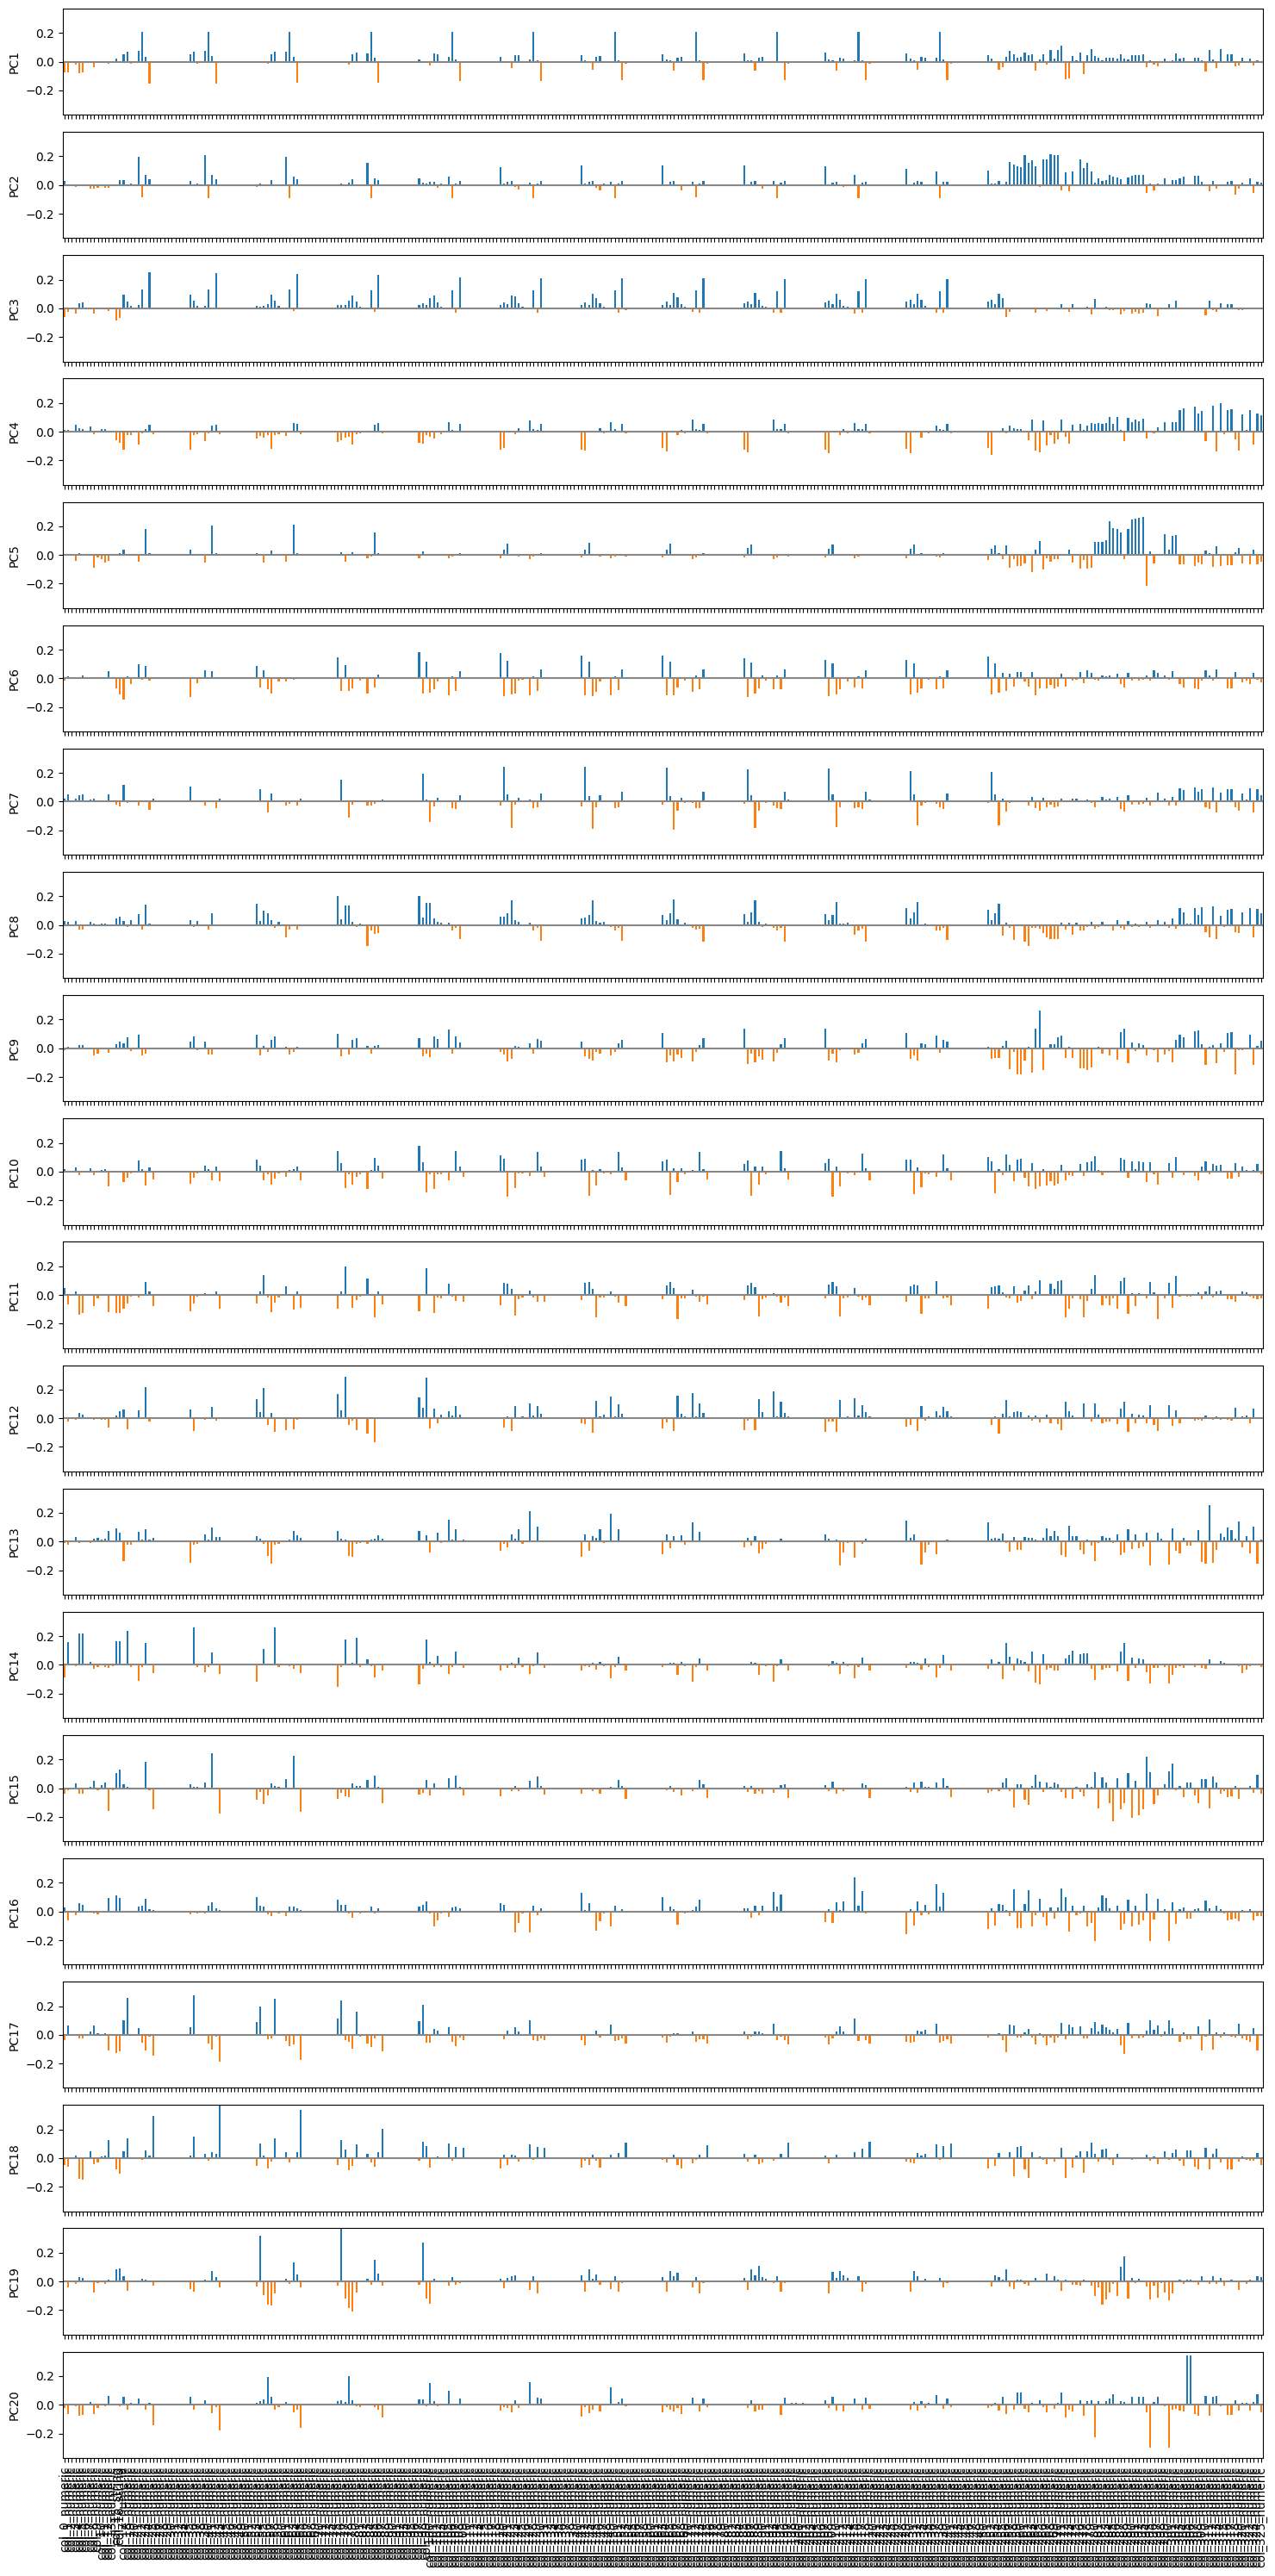

,col_0_numeric,col_1_numeric,col_2_numeric,col_3_numeric,col_4_numeric,col_5_numeric,col_6_numeric,col_7_numeric,col_8_numeric,col_9_numeric,col_10_numeric,col_11_numeric,col_12_numeric,col_13_numeric,col_15_string,col_16_string,col_17_numeric,col_18_numeric,col_19_numeric,col_20_numeric,col_21_numeric,col_22_numeric,col_23_numeric,col_24_numeric,col_25_numeric,col_26_numeric,col_27_numeric,col_28_numeric,col_29_numeric,col_30_numeric,col_31_numeric,col_32_numeric,col_33_numeric,col_34_numeric,col_35_numeric,col_36_numeric,col_37_numeric,col_38_numeric,col_39_numeric,col_40_numeric,col_41_numeric,col_42_numeric,col_43_numeric,col_44_numeric,col_45_numeric,col_46_numeric,col_47_numeric,col_48_numeric,col_49_numeric,col_50_numeric,col_51_numeric,col_52_numeric,col_53_numeric,col_54_numeric,col_55_numeric,col_56_numeric,col_57_numeric,col_58_numeric,col_59_numeric,col_60_numeric,col_61_numeric,col_62_numeric,col_63_numeric,col_64_numeric,col_65_numeric,col_66_numeric,col_67_numeric,col_68_numeric,col_69_numeric,col_70_numeric,col_71_numeric,col_72_numeric,col_73_numeric,col_74_numeric,col_75_numeric,col_76_numeric,col_77_numeric,col_78_numeric,col_79_numeric,col_80_numeric,col_81_numeric,col_82_numeric,col_83_numeric,col_84_numeric,col_85_numeric,col_86_numeric,col_87_numeric,col_88_numeric,col_89_numeric,col_90_numeric,col_91_numeric,col_92_numeric,col_93_numeric,col_94_numeric,col_95_numeric,col_96_numeric,col_97_numeric,col_98_numeric,col_99_numeric,col_100_numeric,col_101_numeric,col_102_numeric,col_103_numeric,col_104_numeric,col_105_numeric,col_106_numeric,col_107_numeric,col_108_numeric,col_109_numeric,col_110_numeric,col_111_numeric,col_112_numeric,col_113_numeric,col_114_numeric,col_115_numeric,col_116_numeric,col_117_numeric,col_118_numeric,col_119_numeric,col_120_numeric,col_121_numeric,col_122_numeric,col_123_numeric,col_124_numeric,col_125_numeric,col_126_numeric,col_127_numeric,col_128_numeric,col_129_numeric,col_130_numeric,col_131_numeric,col_132_numeric,col_133_numeric,col_134_numeric,col_135_numeric,col_136_numeric,col_137_numeric,col_138_numeric,col_139_numeric,col_140_numeric,col_141_numeric,col_142_numeric,col_143_numeric,col_144_numeric,col_145_numeric,col_146_numeric,col_147_numeric,col_148_numeric,col_149_numeric,col_150_numeric,col_151_numeric,col_152_numeric,col_153_numeric,col_154_numeric,col_155_numeric,col_156_numeric,col_157_numeric,col_158_numeric,col_159_numeric,col_160_numeric,col_161_numeric,col_162_numeric,col_163_numeric,col_164_numeric,col_165_numeric,col_166_numeric,col_167_numeric,col_168_numeric,col_169_numeric,col_170_numeric,col_171_numeric,col_172_numeric,col_173_numeric,col_174_numeric,col_175_numeric,col_176_numeric,col_177_numeric,col_178_numeric,col_179_numeric,col_180_numeric,col_181_numeric,col_182_numeric,col_183_numeric,col_184_numeric,col_185_numeric,col_186_numeric,col_187_numeric,col_188_numeric,col_189_numeric,col_190_numeric,col_191_numeric,col_192_numeric,col_193_numeric,col_194_numeric,col_195_numeric,col_196_numeric,col_197_numeric,col_198_numeric,col_199_numeric,col_200_numeric,col_201_numeric,col_202_numeric,col_203_numeric,col_204_numeric,col_205_numeric,col_206_numeric,col_207_numeric,col_208_numeric,col_209_numeric,col_210_numeric,col_211_numeric,col_212_numeric,col_213_numeric,col_214_numeric,col_215_numeric,col_216_numeric,col_217_numeric,col_218_numeric,col_219_numeric,col_220_numeric,col_221_numeric,col_222_numeric,col_223_numeric,col_224_numeric,col_225_numeric,col_226_numeric,col_227_numeric,col_228_numeric,col_229_numeric,col_230_numeric,col_231_numeric,col_232_numeric,col_233_numeric,col_234_numeric,col_235_numeric,col_236_numeric,col_237_numeric,col_238_numeric,col_239_numeric,col_240_numeric,col_241_numeric,col_242_numeric,col_243_numeric,col_244_numeric,col_245_numeric,col_246_numeric,col_247_numeric,col_248_numeric,col_249_numeric,col_250_numeric,col_251_numeric,col_252_numeric,col_253_numeric,col_254_numeric,col_255_numeric,col_256_numeric,col_257_numeri

In [29]:
# Step 5: PCA analysis
eda.pca_analysis(n_components=100, n_loadings_components=20, missing_value_strategy='zerofill', loads_figsize=(15, 30))

In [14]:
sample_df.dtypes

col_0_numeric             float32
col_1_numeric             float32
col_2_numeric             float32
col_3_numeric             float32
col_4_numeric             float32
col_5_numeric             float32
col_6_numeric             float32
col_7_numeric             float32
col_8_numeric             float32
col_9_numeric             float64
col_10_numeric            float32
col_11_numeric            float32
col_12_numeric            float64
col_13_numeric            float64
col_14_other             category
col_15_string               int64
col_16_string               int64
col_17_numeric            float32
col_18_numeric            float32
col_19_numeric            float32
col_20_numeric            float32
col_21_numeric            float32
col_22_numeric            float32
col_23_numeric            float32
col_24_numeric            float32
col_25_numeric            float64
col_26_numeric            float64
col_27_numeric            float64
col_28_numeric            float64
col_29_numeric

Insights:
- Missing values: There are substantial missing values in the data. I have not looked at correlations between them, but I believe they are, as the data (albeit without much context or schema) could pertain to different behaviours measured using different input metrics - it may show up in the correlation matrix in any case with any kind of non-zero imputation.
- Correlations: We do notice many clusters of variables within the 300+ raw features we have which are strongly and weakly positively correlated and some clusters of variables which are strongly and weakly negatively correlated. This could pose problems of multicollinearity, which we either need to deal with in the raw features by dropping correlated features or via PCA/TSNE/other dimensionality reduction techniques.
- Dimensionality Reduction: The variables themselves are quite informative, but do present themselves reasonably well to at least some dimensionality reduction (at least via PCA) it seems. Looking at the explained variance plots and the loadings, it seems we reach 90% explained variance at around 100 components, say, which is around 25-30% of the original dataset dimensionality - not bad?
- Class imbalance: Indeed, the class "Interrupted" is the minority class, with 20-25% of the values in the data having this label. So we need to either over-sample it, or under-sample the majority class.


In [ ]:
# Step 6: TSNE analysis
#eda.tsne_analysis(missing_value_strategy='zerofill')

## Feature Engineering

In this section we perform feature engineering by making use of the insights we gained from the exploratory data analysis and address such issues as multicollinearity, dimensionality reduction, missing values, class imbalance, and distribution skewness (via log/power transformations).

We will make use of the helper tools FeatureEngineer to, well, engineer features for us, and ClassRebalancer to rebalance classes. These are written as TransformerMixins in the style of scikit-learn, so that we can repurpose them for our model pipelines for cleaner and more readable experiments, and so that we can maintain states for such artefacts as the multicollinearity detection and resultant feature selection.

In [60]:
feature_engineer = features.FeatureEngineer.FeatureEngineer(imputation_strategy='median', use_pca=True, n_components=100)
class_rebalancer = datautils.ClassRebalancer.ClassRebalancer(method='undersample')


X = sample_df.drop(columns=['label'])
y = sample_df['label']

# Step 1: Label Encoding for the target variable 'label'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 2: Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'float32', 'int64']).columns

# Step 3: Define preprocessing for categorical and numerical features
# For numerical features: Imputation and scaling
# For categorical features: One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', FunctionTransformer(lambda x: x), numerical_cols),  # Impute missing values for numericals
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical variables
    ]
)

# Step 4: Split the preprocessed data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

pd.DataFrame(X_train).head()

,col_0_numeric,col_1_numeric,col_2_numeric,col_3_numeric,col_4_numeric,col_5_numeric,col_6_numeric,col_7_numeric,col_8_numeric,col_9_numeric,col_10_numeric,col_11_numeric,col_12_numeric,col_13_numeric,col_14_other,col_15_string,col_16_string,col_17_numeric,col_18_numeric,col_19_numeric,col_20_numeric,col_21_numeric,col_22_numeric,col_23_numeric,col_24_numeric,col_25_numeric,col_26_numeric,col_27_numeric,col_28_numeric,col_29_numeric,col_30_numeric,col_31_numeric,col_32_numeric,col_33_numeric,col_34_numeric,col_35_numeric,col_36_numeric,col_37_numeric,col_38_numeric,col_39_numeric,col_40_numeric,col_41_numeric,col_42_numeric,col_43_numeric,col_44_numeric,col_45_numeric,col_46_numeric,col_47_numeric,col_48_numeric,col_49_numeric,col_50_numeric,col_51_numeric,col_52_numeric,col_53_numeric,col_54_numeric,col_55_numeric,col_56_numeric,col_57_numeric,col_58_numeric,col_59_numeric,col_60_numeric,col_61_numeric,col_62_numeric,col_63_numeric,col_64_numeric,col_65_numeric,col_66_numeric,col_67_numeric,col_68_numeric,col_69_numeric,col_70_numeric,col_71_numeric,col_72_numeric,col_73_numeric,col_74_numeric,col_75_numeric,col_76_numeric,col_77_numeric,col_78_numeric,col_79_numeric,col_80_numeric,col_81_numeric,col_82_numeric,col_83_numeric,col_84_numeric,col_85_numeric,col_86_numeric,col_87_numeric,col_88_numeric,col_89_numeric,col_90_numeric,col_91_numeric,col_92_numeric,col_93_numeric,col_94_numeric,col_95_numeric,col_96_numeric,col_97_numeric,col_98_numeric,col_99_numeric,col_100_numeric,col_101_numeric,col_102_numeric,col_103_numeric,col_104_numeric,col_105_numeric,col_106_numeric,col_107_numeric,col_108_numeric,col_109_numeric,col_110_numeric,col_111_numeric,col_112_numeric,col_113_numeric,col_114_numeric,col_115_numeric,col_116_numeric,col_117_numeric,col_118_numeric,col_119_numeric,col_120_numeric,col_121_numeric,col_122_numeric,col_123_numeric,col_124_numeric,col_125_numeric,col_126_numeric,col_127_numeric,col_128_numeric,col_129_numeric,col_130_numeric,col_131_numeric,col_132_numeric,col_133_numeric,col_134_numeric,col_135_numeric,col_136_numeric,col_137_numeric,col_138_numeric,col_139_numeric,col_140_numeric,col_141_numeric,col_142_numeric,col_143_numeric,col_144_numeric,col_145_numeric,col_146_numeric,col_147_numeric,col_148_numeric,col_149_numeric,col_150_numeric,col_151_numeric,col_152_numeric,col_153_numeric,col_154_numeric,col_155_numeric,col_156_numeric,col_157_numeric,col_158_numeric,col_159_numeric,col_160_numeric,col_161_numeric,col_162_numeric,col_163_numeric,col_164_numeric,col_165_numeric,col_166_numeric,col_167_numeric,col_168_numeric,col_169_numeric,col_170_numeric,col_171_numeric,col_172_numeric,col_173_numeric,col_174_numeric,col_175_numeric,col_176_numeric,col_177_numeric,col_178_numeric,col_179_numeric,col_180_numeric,col_181_numeric,col_182_numeric,col_183_numeric,col_184_numeric,col_185_numeric,col_186_numeric,col_187_numeric,col_188_numeric,col_189_numeric,col_190_numeric,col_191_numeric,col_192_numeric,col_193_numeric,col_194_numeric,col_195_numeric,col_196_numeric,col_197_numeric,col_198_numeric,col_199_numeric,col_200_numeric,col_201_numeric,col_202_numeric,col_203_numeric,col_204_numeric,col_205_numeric,col_206_numeric,col_207_numeric,col_208_numeric,col_209_numeric,col_210_numeric,col_211_numeric,col_212_numeric,col_213_numeric,col_214_numeric,col_215_numeric,col_216_numeric,col_217_numeric,col_218_numeric,col_219_numeric,col_220_numeric,col_221_numeric,col_222_numeric,col_223_numeric,col_224_numeric,col_225_numeric,col_226_numeric,col_227_numeric,col_228_numeric,col_229_numeric,col_230_numeric,col_231_numeric,col_232_numeric,col_233_numeric,col_234_numeric,col_235_numeric,col_236_numeric,col_237_numeric,col_238_numeric,col_239_numeric,col_240_numeric,col_241_numeric,col_242_numeric,col_243_numeric,col_244_numeric,col_245_numeric,col_246_numeric,col_247_numeric,col_248_numeric,col_249_numeric,col_250_numeric,col_251_numeric,col_252_numeric,col_253_numeric,col_254_numeric,col_255_numeric,col_256_numeric,c

In [63]:

# Step 5: Define the full pipeline including feature engineering and the classifier

# Logistic Regression Pipeline
logistic_pipeline = Pipeline([
    ('preprocessing', preprocessor),  # Preprocessing (one-hot encoding + imputation)
    ('feature_engineering', feature_engineer),  # Feature engineering (imputation, PCA, scaling)
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Logistic Regression
])

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),  # Preprocessing (one-hot encoding + imputation)
    ('feature_engineering', feature_engineer),  # Feature engineering (imputation, PCA, scaling)
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest
])

# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),  # Preprocessing (one-hot encoding + imputation)
    ('feature_engineering', feature_engineer),  # Feature engineering (imputation, PCA, scaling)
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))  # XGBoost
])

# Step 6: Apply class rebalancing (undersampling) only on the training set
X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)
#X_train_resampled, y_train_resampled = pd.DataFrame(X_train_resampled), y_train_resampled

# Step 7: Fit the pipeline on the resampled training data

print("Now fitting the logistic regression model...")
logistic_pipeline.fit(X_train_resampled, y_train_resampled)
print("Now fitting the random forest model...")
rf_pipeline.fit(X_train_resampled, y_train_resampled)
print("Now fitting the XG boost model...")
xgb_pipeline.fit(X_train_resampled, y_train_resampled)

# Step 8: Predict and evaluate on the test set
#predictions = pipeline.predict(X_test)

# Example of decoding the labels back to original names (optional, for interpretability)
#predictions_decoded = label_encoder.inverse_transform(predictions)

Now fitting the logistic regression model...


c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now fitting the random forest model...
Now fitting the XG boost model...


c:\Users\vctrg\OneDrive\Documents\Github\CastAITask\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:10:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  FunctionTransformer(func=<function <lambda> at 0x00000280137763E0>),
                                                  Index(['col_0_numeric', 'col_1_numeric', 'col_2_numeric', 'col_3_numeric',
       'col_4_numeric', 'col_5_numeric', 'col_6_numeric', 'col_7_numeric',
       'col_8_numeric', 'col_9_numeric',
       ...
       'col_316_numeric', 'col_317_numeric', 'col_31...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [64]:
# Step 9: Evaluate the models on the validation data
def evaluate_model(model, X_val, y_val):
    # Predict probabilities for ROC AUC
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = model.predict(X_val)

    # Compute metrics
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    return {'ROC AUC': roc_auc, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

logistic_results = evaluate_model(logistic_pipeline, X_val, y_val)
rf_results = evaluate_model(rf_pipeline, X_val, y_val)
xgb_results = evaluate_model(xgb_pipeline, X_val, y_val)

# Display results
print("Logistic Regression Results:", logistic_results)
print("Random Forest Results:", rf_results)
print("XGBoost Results:", xgb_results)


Logistic Regression Results: {'ROC AUC': np.float64(0.7771506072718218), 'Precision': np.float64(0.405930721069753), 'Recall': np.float64(0.7449674496744968), 'F1 Score': np.float64(0.5255116077286098)}
Random Forest Results: {'ROC AUC': np.float64(0.9595937157809201), 'Precision': np.float64(0.6771807275961559), 'Recall': np.float64(0.936489364893649), 'F1 Score': np.float64(0.7860002517940324)}
XGBoost Results: {'ROC AUC': np.float64(0.9437631522339346), 'Precision': np.float64(0.6587502982193593), 'Recall': np.float64(0.9111991119911199), 'F1 Score': np.float64(0.7646777442094662)}


In [66]:
import mlflow
import mlflow.sklearn
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

feature_engineer = features.FeatureEngineer.FeatureEngineer(imputation_strategy='median', use_pca=True, n_components=100)
class_rebalancer = datautils.ClassRebalancer.ClassRebalancer(method='undersample')


X = mini_sample_df.drop(columns=['label'])
y = mini_sample_df['label']

# Step 1: Label Encoding for the target variable 'label'
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 2: Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'float32', 'int64']).columns

# Step 3: Define preprocessing for categorical and numerical features
# For numerical features: Imputation and scaling
# For categorical features: One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', FunctionTransformer(lambda x: x), numerical_cols),  # Impute missing values for numericals
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # One-hot encode categorical variables
    ]
)

# Step 4: Split the preprocessed data into train, validation, and test sets (60% train, 20% validation, 20% test)
X_train, X_val, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Initialize MLflow experiment
print("Setting up the MLflow experiment...")
mlflow.set_experiment("MLflow Hyperparameter Optimization Experiment")

# Step 1: Define objective functions for hyperparameter tuning
def optimize_logistic_regression(params):
    with mlflow.start_run(nested=True):
        # Define the model with the given hyperparameters
        model = LogisticRegression(max_iter=1000, C=params['C'], random_state=42)
        
        # Create a pipeline with preprocessing and feature engineering
        pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('feature_engineering', feature_engineer),
            ('classifier', model)
        ])
        
        # Apply class rebalancing to the training set
        X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)
        
        # Evaluate the model using cross-validation
        score = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=3, scoring='roc_auc').mean()
        
        # Log the parameters and score in MLflow
        mlflow.log_param('C', params['C'])
        mlflow.log_metric('roc_auc', score)
        
        return {'loss': -score, 'status': STATUS_OK}

# Define the hyperparameter space for logistic regression
space_logistic = {
    'C': hp.uniform('C', 0.001, 10)  # Regularization strength
}

# Step 2: Define hyperparameter spaces for Random Forest and XGBoost
def optimize_random_forest(params):
    with mlflow.start_run(nested=True):
        model = RandomForestClassifier(n_estimators=int(params['n_estimators']), 
                                       max_depth=int(params['max_depth']), 
                                       random_state=42)
        
        pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('feature_engineering', feature_engineer),
            ('classifier', model)
        ])
        
        X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)
        score = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=3, scoring='roc_auc').mean()
        
        mlflow.log_param('n_estimators', params['n_estimators'])
        mlflow.log_param('max_depth', params['max_depth'])
        mlflow.log_metric('roc_auc', score)
        
        return {'loss': -score, 'status': STATUS_OK}

space_rf = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1)
}

def optimize_xgboost(params):
    with mlflow.start_run(nested=True):
        model = XGBClassifier(use_label_encoder=False, 
                              eval_metric='logloss',
                              n_estimators=int(params['n_estimators']),
                              max_depth=int(params['max_depth']),
                              learning_rate=params['learning_rate'],
                              random_state=42)
        
        pipeline = Pipeline([
            ('preprocessing', preprocessor),
            ('feature_engineering', feature_engineer),
            ('classifier', model)
        ])
        
        X_train_resampled, y_train_resampled = class_rebalancer.transform(X_train, y_train)
        score = cross_val_score(pipeline, X_train_resampled, y_train_resampled, cv=3, scoring='roc_auc').mean()
        
        mlflow.log_param('n_estimators', params['n_estimators'])
        mlflow.log_param('max_depth', params['max_depth'])
        mlflow.log_param('learning_rate', params['learning_rate'])
        mlflow.log_metric('roc_auc', score)
        
        return {'loss': -score, 'status': STATUS_OK}

space_xgb = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
}

# Step 3: Run the optimization using Hyperopt
# Logistic Regression Optimization
print("Now optimising the logistic regression model... ")
trials_logistic = Trials()
best_logistic = fmin(fn=optimize_logistic_regression, 
                     space=space_logistic, 
                     algo=tpe.suggest, 
                     max_evals=50, 
                     trials=trials_logistic)

# Random Forest Optimization
print("Now optimising the random forest model... ")
trials_rf = Trials()
best_rf = fmin(fn=optimize_random_forest, 
               space=space_rf, 
               algo=tpe.suggest, 
               max_evals=50, 
               trials=trials_rf)

# XGBoost Optimization
print("Now optimising the xgboost model... ")
trials_xgb = Trials()
best_xgb = fmin(fn=optimize_xgboost, 
                space=space_xgb, 
                algo=tpe.suggest, 
                max_evals=50, 
                trials=trials_xgb)

print("Best Hyperparameters for Logistic Regression:", best_logistic)
print("Best Hyperparameters for Random Forest:", best_rf)
print("Best Hyperparameters for XGBoost:", best_xgb)


KeyboardInterrupt: 

In [34]:
sample_df.sample(frac=0.01, random_state=42).to_parquet('../data/small_sample_data.parquet')

In [31]:
sample_df.memory_usage(deep=True).sum()

np.int64(1348545124)

In [32]:
1348545124/1024/1024

1286.0728492736816